# Estabilidad de la simulación, métricas y gráficas


En este notebook se quiere tocar 3 temas:

- La variabilidad de una simulación "healthy" en Brian2.
- Ver qué métricas se pueden usar para evaluar los daños neuronales.
- Qué gráficas realizar para visualizar las métricas.


In [25]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from LennartToellke_files.plotting_Toellke import *
from event_detection_JuanLuis import event_detection
from pathlib import Path
import os
from brian2 import *
from plotting_JuanLuis import *

# Calculamos la ruta a la carpeta del notebook
notebook_folder = Path(os.getcwd())

## Comprobar la variabilidad de las simulaciones de Brian2


Nos guardamos todos los resultados de las simulaciones para poder analizarlos posteriormente.


In [26]:
# Localizamos la ruta de los resultados
results_folder = notebook_folder.parent / "results" / "healthy_validation"

# Cremaos una lista para almacenar los resultados
lfp_data = []

# Hacemos un bucle para recorrer todas las carpetas dentr de results_folder
# y leer los archivos LFP.txt que hay dentro de las carpetas
for folder in results_folder.iterdir():
    if folder.is_dir():
        # Leer los resultados del archivo LFP.txt
        lfp = create_list_from_timeSeries(folder / "LFP.txt")
        lfp_data.append(np.array(lfp))

print(f"Se han encontrado {len(lfp_data)} archivos LFP.txt")

Se han encontrado 10 archivos LFP.txt


Dividimos en tres tipos principales de datos (`eventos`, `ripples`, `psd`).


In [30]:
# Sacamos los datos de cada archivo LFP.txt
event_data = []
ripple_data = []
psd_bands = []
for lfp in lfp_data:
    events, _, _, ripple, psd_band = event_detection(lfp, scaling="spectrum")
    event_data.append(events)
    ripple_data.append(ripple)
    psd_bands.append(psd_band)

Vamos a analizar la variación en las bandas de densidad de potencia.


In [31]:
# Diccionarios donde guardamos media y SEM (tal como antes)
theta_bands = {"mean": [], "std": []}
gamma_bands = {"mean": [], "std": []}
ripple_bands = {"mean": [], "std": []}

# Listas nuevas para guardar los valores “crudos” de cada simulación
# Cada elemento de theta_values_per_sim será, por ejemplo, un array de potencias theta para esa simulación
theta_values_per_sim = []
gamma_values_per_sim = []
ripple_values_per_sim = []

for psd_band in psd_bands:
    # psd_band es iterable de 3 arrays: [theta_array, gamma_array, ripple_array]
    theta_array, gamma_array, ripple_array = psd_band

    # 1.a) Guardamos los vectores crudos en las listas correspondientes
    theta_values_per_sim.append(theta_array)
    gamma_values_per_sim.append(gamma_array)
    ripple_values_per_sim.append(ripple_array)

    # 1.b) Calculamos la media de cada array y la guardamos en el diccionario de “mean”
    theta_bands["mean"].append(np.mean(theta_array))
    gamma_bands["mean"].append(np.mean(gamma_array))
    ripple_bands["mean"].append(np.mean(ripple_array))

    # 1.c) Calculamos el SEM de cada array y lo guardamos en el diccionario de “std”
    #     (tal como lo hacías: std() / sqrt(N))
    N_theta = len(theta_array)
    N_gamma = len(gamma_array)
    N_ripple = len(ripple_array)

    theta_bands["std"].append(np.std(theta_array) / np.sqrt(N_theta))
    gamma_bands["std"].append(np.std(gamma_array) / np.sqrt(N_gamma))
    ripple_bands["std"].append(np.std(ripple_array) / np.sqrt(N_ripple))

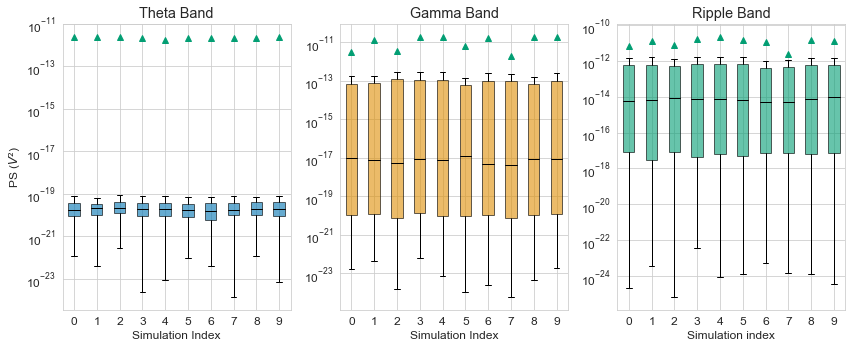

In [35]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 12})   # <— aquí cambiamos la fuente a 16

colorblind = sns.color_palette("colorblind", 8)
fig_box, axs_box = plt.subplots(1, 3, figsize=(12, 5))

N_sim = len(theta_values_per_sim)

# --- Banda Theta ---
axs_box[0].boxplot(
    theta_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[0], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[0].set_yscale('log')
axs_box[0].set_title("Theta Band")
axs_box[0].set_xlabel("Simulation Index")
axs_box[0].set_ylabel("PS ($V²$)")
axs_box[0].set_xticks(np.arange(1, N_sim + 1))
axs_box[0].set_xticklabels(np.arange(N_sim))

# --- Banda Gamma ---
axs_box[1].boxplot(
    gamma_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[1], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[1].set_yscale('log')
axs_box[1].set_title("Gamma Band")
axs_box[1].set_xlabel("Simulation Index")
axs_box[1].set_xticks(np.arange(1, N_sim + 1))
axs_box[1].set_xticklabels(np.arange(N_sim))

# --- Banda Ripple ---
axs_box[2].boxplot(
    ripple_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[2], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    showmeans=True
)
axs_box[2].set_yscale('log')
axs_box[2].set_title("Ripple Band")
axs_box[2].set_xlabel("Simulation index")
axs_box[2].set_xticks(np.arange(1, N_sim + 1))
axs_box[2].set_xticklabels(np.arange(N_sim))

fig_box.tight_layout()
plt.show()

Ahora analizaremos la variación en las frecuencias pico.


In [6]:
# Diccionarios donde seguiremos guardando media y “std” (como en tu código original)
events_pf = {"mean": [], "std": []}
ripple_pf = {"mean": [], "std": []}

# Nuevas listas para almacenar los vectores crudos de cada simulación
events_values_per_sim = []
ripple_values_per_sim = []

# Recorremos evento y ripple por simulación
for events, ripples in zip(event_data, ripple_data):
    # events[2] es el array de frecuencias pico de eventos de esta simulación
    # ripples[1] es el array de frecuencias pico de ripples de esta simulación

    # 1.a) Guardamos los vectores crudos
    events_values_per_sim.append(events[2])
    ripple_values_per_sim.append(ripples[1])

    # 1.b) Calculamos la media de cada array
    mean_events = np.mean(events[2])
    mean_ripples = np.mean(ripples[1])
    events_pf["mean"].append(mean_events)
    ripple_pf["mean"].append(mean_ripples)

    # 1.c) Calculamos el “error” (tú lo definías como std/len). Lo dejamos igual:
    sem_events = np.std(events[2]) / len(events[2])
    sem_ripples = np.std(ripples[1]) / len(ripples[1])
    events_pf["std"].append(sem_events)
    ripple_pf["std"].append(sem_ripples)

WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double

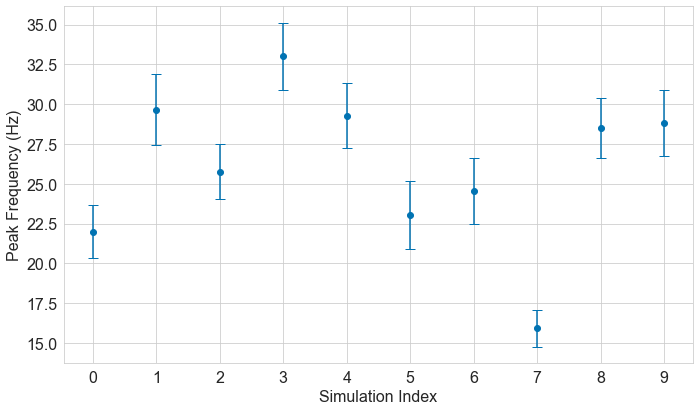

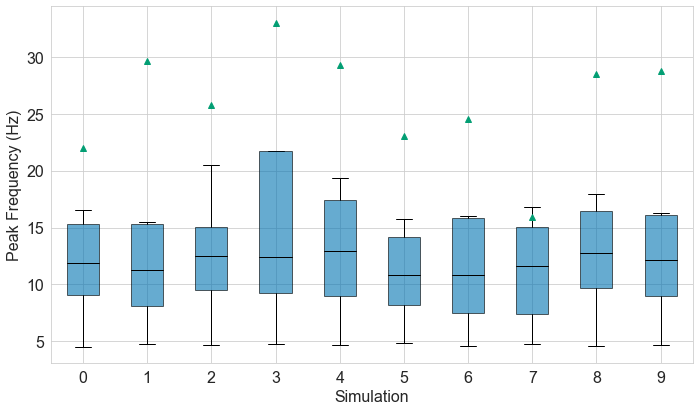

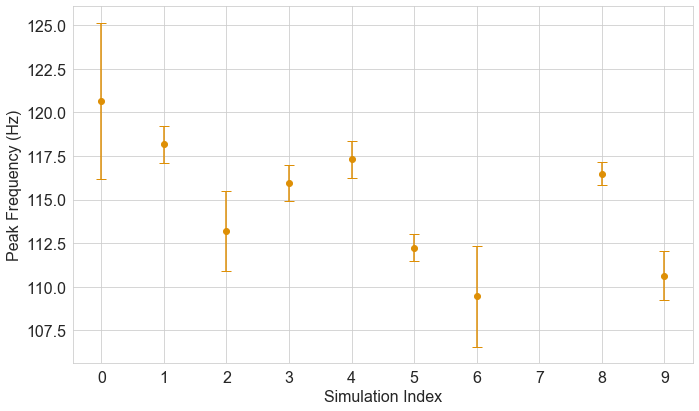

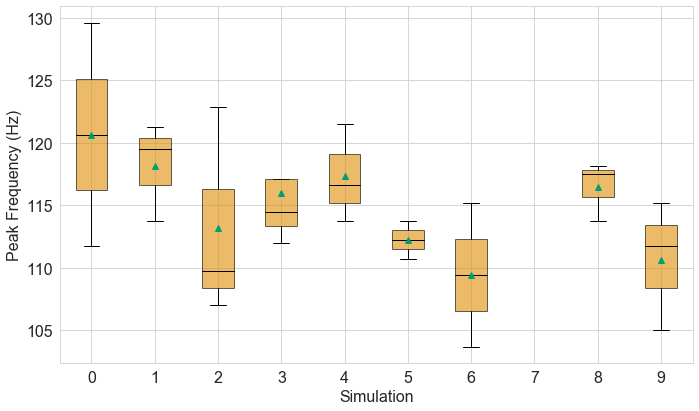

In [23]:
plt.rcParams.update({'font.size': 16})

# 1) Event Peak Frequencies (Mean ± Error)
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.errorbar(
    np.arange(len(events_pf["mean"])),
    events_pf["mean"],
    yerr=events_pf["std"],
    fmt='o',
    capsize=5,
    color=colorblind[0],
    zorder=3
)
ax1.set_xlabel("Simulation Index")
ax1.set_ylabel("Peak Frequency (Hz)")
ax1.set_xticks(np.arange(len(events_pf["mean"])))
fig1.tight_layout()
plt.show()

# 2) Event Peak Frequencies (Boxplot)
plt.rcParams.update({'font.size': 16})
fig2, ax2 = plt.subplots(figsize=(10, 6))
N_sim_events = len(events_values_per_sim)
ax2.boxplot(
    events_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[0], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
ax2.set_xlabel("Simulation")
ax2.set_ylabel("Peak Frequency (Hz)")
ax2.set_xticks(np.arange(1, N_sim_events + 1))
ax2.set_xticklabels(np.arange(N_sim_events))
fig2.tight_layout()
plt.show()

# 3) Ripple Peak Frequencies (Mean ± Error)
plt.rcParams.update({'font.size': 16})
fig3, ax3 = plt.subplots(figsize=(10, 6))
ax3.errorbar(
    np.arange(len(ripple_pf["mean"])),
    ripple_pf["mean"],
    yerr=ripple_pf["std"],
    fmt='o',
    capsize=5,
    color=colorblind[1],
    zorder=3
)
ax3.set_xlabel("Simulation Index")
ax3.set_ylabel("Peak Frequency (Hz)")
ax3.set_xticks(np.arange(len(ripple_pf["mean"])))
fig3.tight_layout()
plt.show()

# 4) Ripple Peak Frequencies (Boxplot)
plt.rcParams.update({'font.size': 16})
fig4, ax4 = plt.subplots(figsize=(10, 6))
N_sim_ripples = len(ripple_values_per_sim)
ax4.boxplot(
    ripple_values_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[1], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=False,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
ax4.set_xlabel("Simulation")
ax4.set_ylabel("Peak Frequency (Hz)")
ax4.set_xticks(np.arange(1, N_sim_ripples + 1))
ax4.set_xticklabels(np.arange(N_sim_ripples))
fig4.tight_layout()
plt.show()

Ahora vamos a analizar la variación del tiempo de duración de los ripples.


In [8]:
# Diccionario para guardar media y SEM (tal como en tu código original)
duration_ripples = {"mean": [], "std": []}

# Nueva lista para almacenar los vectores crudos de duración de ripples por simulación
duration_ripples_per_sim = []

# Recorremos cada conjunto de ripples en ripple_data
for ripples in ripple_data:
    # ripples[2] es el array de duraciones de ripples de esta simulación

    # 1.a) Guardamos el vector crudo
    duration_ripples_per_sim.append(ripples[2])

    # 1.b) Calculamos la media de ese array y la guardamos
    mean_duration = np.mean(ripples[2])
    duration_ripples["mean"].append(mean_duration)

    # 1.c) Calculamos el SEM tal como lo hacías: std() / N
    sem_duration = np.std(ripples[2]) / len(ripples[2])
    duration_ripples["std"].append(sem_duration)

WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
 [py.warnings]
WARNING    /home/juan-luis/miniconda3/envs/hipp_sim/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double

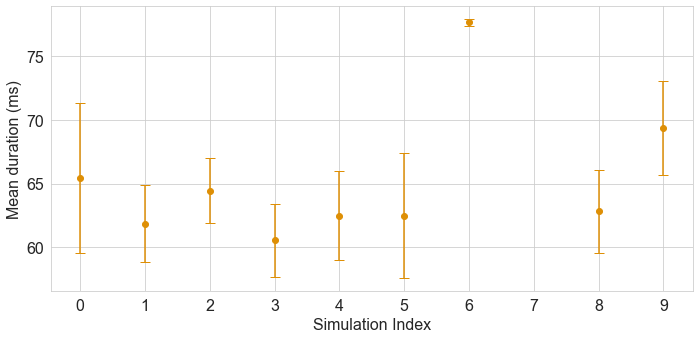

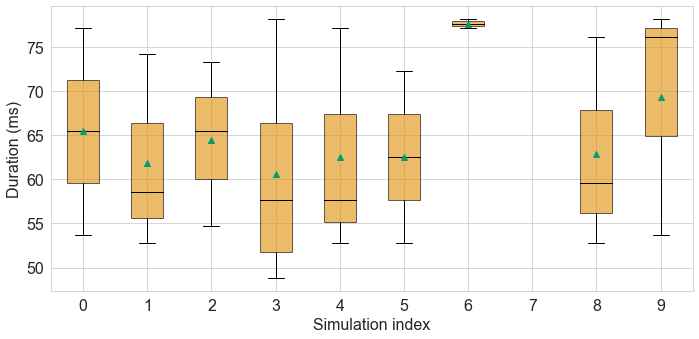

In [24]:
plt.rcParams.update({'font.size': 16})

fig4, ax4 = plt.subplots(figsize=(10, 5))
ax4.errorbar(
    np.arange(len(duration_ripples["mean"])),
    duration_ripples["mean"],
    yerr=duration_ripples["std"],
    fmt='o',
    capsize=5,
    color=colorblind[1],
    zorder=3
)
ax4.set_ylabel("Mean duration (ms)")
ax4.set_xlabel("Simulation Index")
ax4.set_xticks(np.arange(len(duration_ripples["mean"])))
fig4.tight_layout()
plt.show()

fig_box4, ax_box4 = plt.subplots(figsize=(10, 5))
ax_box4.boxplot(
    duration_ripples_per_sim,
    patch_artist=True,
    boxprops=dict(facecolor=colorblind[1], alpha=0.6),
    medianprops=dict(color="black"),
    showfliers=True,
    flierprops=dict(marker='o', color='black', alpha=0.5, markersize=4),
    showmeans=True
)
ax_box4.set_xlabel("Simulation index")
ax_box4.set_ylabel("Duration (ms)")
N_sim_duration = len(duration_ripples_per_sim)
ax_box4.set_xticks(np.arange(1, N_sim_duration + 1))
ax_box4.set_xticklabels(np.arange(N_sim_duration))
fig_box4.tight_layout()
plt.show()


## Métricas


Ahora vamos a ver qué métricas podemos usar para evlaluar los daños neuronales. Hay que tener en cuenta que debido a la "inestabilidad" de las simulaciones, necesitamos realizar varias a la vez, por lo que habrá que pensar también si es necesario representar algo más que una media y un error estándar de esta media.


La función `event_detection` del trabajo de Toellke nos proporciona los siguinetes datos a partir de un archivo `LFP.txt`:

- **Datos relacionados con eventos:**
  - Lista de eventos.
  - Lista de eventos filtrados.
  - Lista de frecuencias pico de cada evento.
  - Lista de las duraciones de cada evento.
- **Datos relacionados con SWRs:**
  - Lista de SWRs.
  - Lista de frecuencias pico de cada SWR.
  - Lista de duraciones de cada SWR.
- **Datos relacionados con la densidad espectral de potencia (PSD):**
  - Lista de densidad espectrla de potencia (PSD) en el rango de frecuencias "theta" (5-10 Hz).
  - Lista de densidad espectral de potencia (PSD) en el rango de frecuencias "gamma" (30-100 Hz).
  - Lista de densidad espectral de potencia (PSD) en el rango de frecuencias "ripples" (100-250 Hz).


A partir de estos datos, podemos probar a calcular las siguientes métricas:

- **Cantidades:**
  - Número de eventos.
  - Número de SWRs.
- **Duraciones:**
  - Duraciones de eventos.
  - Duraciones de SWRs.
- **Frecuencias:**
  - Frecuencias pico de eventos.
  - Frecuencias pico de SWRs.
- **Potencias:**
  - Potencia en el rango de frecuencias "theta".
  - Potencia en el rango de frecuencias "gamma".
  - Potencia en el rango de frecuencias "ripples".


In [10]:
# Seleccionamos la cantidad de experimentos scanning y nonce
n_healthy = 10
n_nonce_standard = 10
n_nonce_aggresive = 10

In [11]:
# Definimos las rutas de las carpetas de validación

# Simulaciones healthy
paths_healthy = []
for i in range(1, n_healthy + 1):
    paths_healthy.append(str(results_folder.parent / f"healthy_{i}"))

# Ataques con parámetros
path_N = str(results_folder.parent / "N")
path_gmaxe = str(results_folder.parent / "gmaxe")
path_gcan = str(results_folder.parent / "gCAN")
path_gach = str(results_folder.parent / "gACh")
path_N_gmaxe = str(results_folder.parent / "N_gmaxe")
path_gcan_gach = str(results_folder.parent / "gCAN_gACh")
path_N_gmaxe_gcan_gach = str(results_folder.parent / "N_gmaxe_gCAN_gACh")

# Ataques modificando archivos EEG
path_flooding = str(results_folder.parent / "flooding")
path_jamming = str(results_folder.parent / "jamming")
path_scanning = str(results_folder.parent / "scanning")
path_forwarding = str(results_folder.parent / "forwarding")
paths_nonce_standard = []
for i in range(1, n_nonce_standard + 1):
    paths_nonce_standard.append(str(results_folder.parent / f"nonce_standard_{i}"))
paths_nonce_aggresive = []
for i in range(1, n_nonce_aggresive + 1):
    paths_nonce_aggresive.append(str(results_folder.parent / f"nonce_aggresive_{i}"))

In [12]:
# Cargamos los datos de las carpetas de validación

# Datos healthy
data_dicts_healthy = []
for path_healthy in paths_healthy:
    data_dict_healthy = data_to_dict(path_healthy)
    data_dicts_healthy.append(data_dict_healthy)

# Datos de ataques con parámetros
data_dict_N = data_to_dict(path_N)
data_dict_gmaxe = data_to_dict(path_gmaxe)
data_dict_gcan = data_to_dict(path_gcan)
data_dict_gach = data_to_dict(path_gach)
data_dict_N_gmaxe = data_to_dict(path_N_gmaxe)
data_dict_gcan_gach = data_to_dict(path_gcan_gach)
data_dict_N_gmaxe_gcan_gach = data_to_dict(path_N_gmaxe_gcan_gach)
data_dicts_parameters = [
    data_dict_N,
    data_dict_gmaxe,
    data_dict_gcan,
    data_dict_gach,
    data_dict_N_gmaxe,
    data_dict_gcan_gach,
    data_dict_N_gmaxe_gcan_gach
]

# Datos de ataques modificando archivos EEG
data_dict_flooding = data_to_dict(path_flooding)
data_dict_jamming = data_to_dict(path_jamming)
data_dict_scanning = data_to_dict(path_scanning)
data_dict_forwarding = data_to_dict(path_forwarding)
data_dicts_eeg = [
    data_dict_flooding,
    data_dict_jamming,
    data_dict_scanning,
    data_dict_forwarding
]
data_dicts_nonce_standard = []
for path_nonce in paths_nonce_standard:
    data_dict_nonce_standard = data_to_dict(path_nonce)
    data_dicts_nonce_standard.append(data_dict_nonce_standard)
data_dicts_nonce_aggresive = []
for path_nonce in paths_nonce_aggresive:
    data_dict_nonce_aggresive = data_to_dict(path_nonce)
    data_dicts_nonce_aggresive.append(data_dict_nonce_aggresive)

In [13]:
# Carpeta para guardas las imágenes de las gráficas
save_path = str(notebook_folder.parent / "imagenes-memoria")

# Creamos las etiquetas para las validaciones y comparaciones

# Labels healthy
labels_healthy = []
for i in range(1, n_healthy + 1):
    labels_healthy.append(f"Healthy {i}")

# Labels de ataques con parámetros
labels_parameters = [
    "N",
    "gmaxe",
    "gcan",
    "gach",
    "N + gmaxe",
    "gcan + gach",
    "N + gmaxe + gcan + gach"
]

# Labels de ataques modificando archivos EEG
labels_eeg = [
    "Flooding",
    "Jamming",
    "Scanning",
    "Forwarding"
]
labels_nonce_standard = []
for i in range(1, n_nonce_standard + 1):
    labels_nonce_standard.append(f"Nonce {i}")
labels_nonce_aggresive = []
for i in range(1, n_nonce_aggresive + 1):
    labels_nonce_aggresive.append(f"Nonce {i}")

### Cantidad de eventos y SWRs


In [14]:
# Nombres de las gráficas para guardar
name_healthy = "results_n_healthy.png"
name_params = "results_n_params.png"
name_eeg = "results_n_eeg.png"
name_nonce = "results_n_nonce.png"
name_nonnce_agg = "results_n_nonce_agg.png"

# Gráficas de validación de simulaciones healthy
lims = n_detects_plot(
    data_dict=data_dicts_healthy,
    labels=labels_healthy,
    figsize=(7, 7),
    return_lims=True,
    ncol=2,
    save_path=save_path + "/" + name_healthy
)

# Gráficas de comparación de healthy con ataques definidos con parámetros de la simulación
n_detects_plot(
    data_dict=data_dicts_parameters,
    labels=labels_parameters,
    figsize=(7, 7),
    lims=lims,
    ncol=3,
    y_lims=(0, 8),
    save_path=save_path + "/" + name_params
)

# Gráficas de comparación de healthy con ataques a los archivos EEG
n_detects_plot(
    data_dict=data_dicts_eeg,
    labels=labels_eeg,
    figsize=(7, 7),
    lims=lims,
    save_path=save_path + "/" + name_eeg
)

# Gráficas de comparación de healthy con nonce 1
n_detects_plot(
    data_dict=data_dicts_nonce_standard,
    labels=labels_nonce_standard,
    figsize=(7, 7),
    lims=lims,
    ncol=3,
    save_path=save_path + "/" + name_nonce
)

# Gráficas de comparación de healthy con nonce 2
n_detects_plot(
    data_dict=data_dicts_nonce_aggresive,
    labels=labels_nonce_aggresive,
    figsize=(7, 7),
    lims=lims,
    ncol=2,
    save_path=save_path + "/" + name_nonnce_agg
)


### Duración de eventos y SWRs


In [15]:
# Nombres de las gráficas para guardar duración de eventos
name_healthy = "results_duration_healthy.png"
name_params = "results_duration_params.png"
name_eeg = "results_duration_eeg.png"
name_nonce = "results_duration_nonce.png"
name_nonce_agg = "results_duration_nonce_agg.png"

# Gráficas de duración de eventos detectados en validaciones healthy
lims = durations_plot(
    data_dict=data_dicts_healthy,
    labels=labels_healthy,
    figsize=(7, 7),
    return_lims=True,
    ncol=2,
    save_path=save_path + "/" + name_healthy
)

# Gráficas de duración de eventos detectados en comparación healthy con ataques
durations_plot(
    data_dict=data_dicts_parameters,
    labels=labels_parameters,
    figsize=(7, 7),
    lims=lims,
    save_path=save_path + "/" + name_params,
)

# Gráficas de duración de eventos detectados en comparación healthy con ataques a los archivos EEG
durations_plot(
    data_dict=data_dicts_eeg,
    labels=labels_eeg,
    figsize=(7, 7),
    lims=lims,
    save_path=save_path + "/" + name_eeg
)

# Gráficas de duración de eventos detectados en comparación healthy con nonce 1
durations_plot(
    data_dict=data_dicts_nonce_standard,
    labels=labels_nonce_standard,
    figsize=(7, 7),
    lims=lims,
    ncol=2,
    save_path=save_path + "/" + name_nonce
)

# Gráficas de duración de eventos detectados en comparación healthy con nonce 2
durations_plot(
    data_dict=data_dicts_nonce_aggresive,
    labels=labels_nonce_aggresive,
    figsize=(7, 7),
    lims=lims,
    ncol=2,
    save_path=save_path + "/" + name_nonce_agg
)

### Frecuencias pico de eventos y SWRs


In [16]:
# Nombres de las gráficas para guardar frecuencias pico de eventos
name_healthy = "results_pf_healthy.png"
name_parameters = "results_pf_parameters.png"
name_eeg = "results_pf_eeg.png"
name_nonce_standard = "results_pf_nonce_standard.png"
name_nonce_aggresive = "results_pf_nonce_agg.png"

# Gráficas de frecuencias pico de eventos detectados en validaciones healthy
lims = peak_freqs_plot(
    data_dict=data_dicts_healthy,
    labels=labels_healthy,
    figsize=(7, 7),
    xrotation=30,
    return_lims=True,
    save_path=save_path + "/" + name_healthy
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con ataques
peak_freqs_plot(
    data_dict=data_dicts_parameters,
    labels=labels_parameters,
    figsize=(7, 7),
    xrotation=30,
    lims=lims,
    save_path=save_path + "/" + name_parameters
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con ataques a los archivos EEG
peak_freqs_plot(
    data_dict=data_dicts_eeg,
    labels=labels_eeg,
    figsize=(7, 7),
    xrotation=30,
    lims=lims,
    save_path=save_path + "/" + name_eeg
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con nonce 1
peak_freqs_plot(
    data_dict=data_dicts_nonce_standard,
    labels=labels_nonce_standard,
    figsize=(7, 7),
    xrotation=30,
    lims=lims,
    save_path=save_path + "/" + name_nonce_standard,
)

# Gráficas de frecuencias pico de eventos detectados en comparación healthy con nonce 2
peak_freqs_plot(
    data_dict=data_dicts_nonce_aggresive,
    labels=labels_nonce_aggresive,
    figsize=(7, 7),
    xrotation=30,
    lims=lims,
    save_path=save_path + "/" + name_nonce_agg
)

### PSD


In [19]:
# Nombres de las gráficas para guardar psd de eventos
name_healthy = "results_psd_healthy.png"
name_parameters = "results_psd_parameters.png"
name_eeg = "results_psd_eeg.png"
name_nonce_standard = "results_psd_nonce_standard.png"
name_nonce_aggresive = "results_psd_nonce_agg.png"

# Gráficas de psd de eventos detectados en validaciones healthy
lims = psd_plot(
    data_dict=data_dicts_healthy,
    labels=labels_healthy,
    figsize=(7, 7),
    return_lims=True,
    ncol=1,
    save_path=save_path + "/" + name_healthy
)

# Gráficas de psd de eventos detectados en comparación healthy con ataques
psd_plot(
    data_dict=data_dicts_parameters,
    labels=labels_parameters,
    figsize=(7, 7),
    lims=lims,
    y_lims=(1e-15, 1e-11),
    ncol=2,
    save_path=save_path + "/" + name_parameters
)

# Gráficas de psd de eventos detectados en comparación healthy con ataques a los archivos EEG
psd_plot(
    data_dict=data_dicts_eeg,
    labels=labels_eeg,
    figsize=(7, 7),
    lims=lims,
    save_path=save_path + "/" + name_eeg
)

# Gráficas de psd de eventos detectados en comparación healthy con nonce 1
psd_plot(
    data_dict=data_dicts_nonce_standard,
    labels=labels_nonce_standard,
    figsize=(7, 7),
    lims=lims,
    y_lims=(1e-14, 2e-12),
    ncol=4,
    save_path=save_path + "/" + name_nonce_standard
)

# Gráficas de psd de eventos detectados en comparación healthy con nonce 2
psd_plot(
    data_dict=data_dicts_nonce_aggresive,
    labels=labels_nonce_aggresive,
    figsize=(7, 7),
    lims=lims,
    ncol=3,
    save_path=save_path + "/" + name_nonce_agg
)

In [20]:
# Vamos a usar PS en vez de PSD para replicar las gráficas de Lennart
n_healthy = 10

# Direcciones de los archivos healthy
healthy_paths = []
for i in range(1, n_healthy + 1):
    healthy_paths.append(str(results_folder.parent / f"healthy_{i}"))

# Diccionarios donde guardamos los datos de las simulaciones healthy
data_dicts_healthy = []
for path_healthy in healthy_paths:
    data_dict_healthy = data_to_dict(path_healthy, scaling="spectrum")
    data_dicts_healthy.append(data_dict_healthy)
    
# Labels para las simulaciones healthy
labels_healthy = []
for i in range(1, n_healthy + 1):
    labels_healthy.append(f"Healthy {i}")

# Nombres de las gráficas para guardar psd de eventos
name_healthy = "results_ps_healthy.png"
name_params = "results_ps_params.png"

# Gráficas de psd de eventos detectados en validaciones healthy
lims = psd_plot(
    data_dict=data_dicts_healthy,
    labels=labels_healthy,
    figsize=(7, 7),
    return_lims=True,
    ncol=1,
    scaling="spectrum",
    save_path=save_path + "/" + name_healthy
)

# Direcciones de los archivos de ataques con parámetros
params_paths = [
    str(results_folder.parent / "N"),
    str(results_folder.parent / "gmaxe"),
    str(results_folder.parent / "gCAN"),
    str(results_folder.parent / "gACh"),
    str(results_folder.parent / "N_gmaxe"),
    str(results_folder.parent / "gCAN_gACh"),
    str(results_folder.parent / "N_gmaxe_gCAN_gACh")
]

# Diccionarios donde guardamos los datos de ataques con parámetros
data_dicts_params = []
for path_param in params_paths:
    data_dict_param = data_to_dict(path_param, scaling="spectrum")
    data_dicts_params.append(data_dict_param)
    
# Labels para los ataques con parámetros
labels_params = [
    "N",
    "gmaxe",
    "gcan",
    "gach",
    "N + gmaxe",
    "gcan + gach",
    "N + gmaxe + gcan + gach"
]

psd_plot(
    data_dict=data_dicts_params,
    labels=labels_params,
    figsize=(7, 7),
    ncol=2,
    lims=lims,
    y_lims=(1e-14, 1e-9),
    scaling="spectrum",
    save_path=save_path + "/" + name_params
)